In [1]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras import layers, models
from sklearn.metrics import precision_score, recall_score, accuracy_score
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


In [3]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

In [4]:
train_dir = "BT100/Training"

# Define augmentation functions
def augment_image(image):
    """Apply rotation, flipping, zoom, brightness, and contrast adjustments."""

    # Random Rotation (-20 to +20 degrees)
    image = tf.image.rot90(image, k=random.choice([0, 1, 2, 3]))

    # Random Flip
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Random Zoom (Crop and Resize)
    crop_fraction = random.uniform(0.7, 1.0)  # Zoom range
    img_shape = tf.shape(image)

    # Cast img_shape elements to float32 before multiplication
    crop_size = [int(tf.cast(img_shape[0], tf.float32) * crop_fraction),
                 int(tf.cast(img_shape[1], tf.float32) * crop_fraction), 3]

    image = tf.image.random_crop(image, crop_size)
    image = tf.image.resize(image, (img_shape[0], img_shape[1]))

    # Random Brightness and Contrast
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    return image

# Process each class in training folder
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path):
        continue  # Skip if not a folder

    # Get image files
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    num_augmented = len(image_files)*2  # Generate 50% more images

    for i in range(num_augmented):
        img_name = random.choice(image_files)  # Pick a random image
        img_path = os.path.join(class_path, img_name)

        # Load image
        image = load_img(img_path)
        image = img_to_array(image) / 255.0  # Normalize

        # Apply augmentation
        augmented_image = augment_image(image)

        # Convert back to image
        augmented_image = array_to_img(augmented_image)

        # Save augmented image in the same folder
        new_filename = f"aug_{i}_{img_name}"
        augmented_image.save(os.path.join(class_path, new_filename))

print("Augmentation complete! Images saved in the existing training folder.")

Augmentation complete! Images saved in the existing training folder.


In [5]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "BT100/Training",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True
)

Found 8574 files belonging to 4 classes.


In [6]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    "BT100/Testing",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

Found 656 files belonging to 4 classes.


In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def create_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [8]:

model = create_model()
model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 111,172 (434.27 KB)

 Trainable params: 110,724 (432.52 KB)

 Non-trainable params: 448 (1.75 KB)

In [9]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

In [10]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=50,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - accuracy: 0.5191 - loss: 1.1406 - val_accuracy: 0.6616 - val_loss: 0.9246 - learning_rate: 1.0000e-04
Epoch 2/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.6816 - loss: 0.8087 - val_accuracy: 0.6494 - val_loss: 0.8187 - learning_rate: 1.0000e-04
Epoch 3/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.7350 - loss: 0.6898 - val_accuracy: 0.7454 - val_loss: 0.6624 - learning_rate: 1.0000e-04
Epoch 4/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.7788 - loss: 0.5945 - val_accuracy: 0.7912 - val_loss: 0.5828 - learning_rate: 1.0000e-04
Epoch 5/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.8096 - loss: 0.5243 - val_accuracy: 0.7851 - val_loss: 0.5798 - learning_rate: 1.0000e-04
Epoch 6/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.8222 - loss: 0.4911 - val_accuracy: 0.8201 - val_loss: 0.4843 - learning_rate: 1.0000e-04
Epoch 7/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step

In [22]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder

# Get true labels from test_data
y_true = []
for images, labels in test_data:
    y_true.extend(labels.numpy())

y_true = np.argmax(y_true, axis=1)  # Convert one-hot to class labels

# Get predictions from the model
y_pred = model.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Calculate accuracy
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

# Convert true labels to one-hot format
encoder = OneHotEncoder(sparse_output=False)  # Ensure dense output
y_true_onehot = encoder.fit_transform(y_true.reshape(-1, 1))
y_pred_onehot = encoder.transform(y_pred.reshape(-1, 1))

# Print classification report
print(classification_report(y_true_onehot, y_pred_onehot, zero_division=1))
`

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Accuracy: 0.8887195121951219
              precision    recall  f1-score   support

           0       0.94      0.81      0.87       150
           1       0.77      0.80      0.78       153
           2       0.93      0.97      0.95       203
           3       0.92      0.95      0.93       150

   micro avg       0.89      0.89      0.89       656
   macro avg       0.89      0.88      0.88       656
weighted avg       0.89      0.89      0.89       656
 samples avg       0.89      0.89      0.89       656



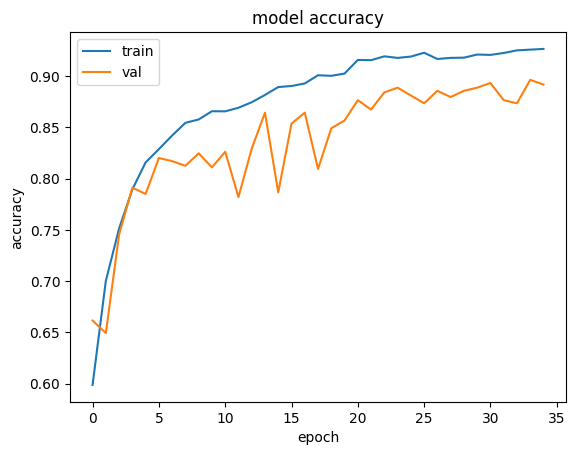

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

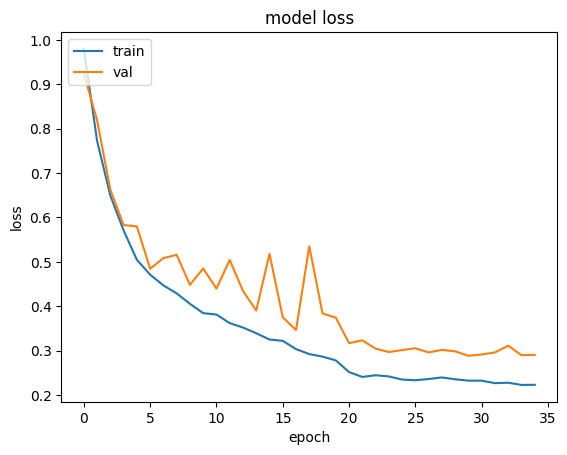

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

def create_refined_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128, 128, 3)),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),

        Conv2D(256, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),

        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(4, activation='softmax')  # 4 classes
    ])

    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model_test = create_refined_model()


In [33]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

In [34]:
myModel = model_test.fit(
    train_data,
    validation_data=test_data,
    epochs=50,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.3894 - loss: 2.2707 - val_accuracy: 0.5320 - val_loss: 1.1106 - learning_rate: 5.0000e-04
Epoch 2/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.6155 - loss: 0.9169 - val_accuracy: 0.6890 - val_loss: 0.8222 - learning_rate: 5.0000e-04
Epoch 3/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.7023 - loss: 0.7471 - val_accuracy: 0.7470 - val_loss: 0.6885 - learning_rate: 5.0000e-04
Epoch 4/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.7827 - loss: 0.5759 - val_accuracy: 0.8125 - val_loss: 0.5292 - learning_rate: 5.0000e-04
Epoch 5/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.8337 - loss: 0.4545 - val_accuracy: 0.7973 - val_loss: 0.5482 - learning_rate: 5.0000e-04
Epoch 6/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.8328 - loss: 0.4572 - val_accuracy: 0.8308 - val_loss: 0.4591 - learning_rate: 5.0000e-04
Epoch 7/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step

In [35]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder

# Get true labels from test_data
y_true = []
for images, labels in test_data:
    y_true.extend(labels.numpy())

y_true = np.argmax(y_true, axis=1)  # Convert one-hot to class labels

# Get predictions from the model
y_pred = model_test.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Calculate accuracy
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

# Convert true labels to one-hot format
encoder = OneHotEncoder(sparse_output=False)  # Ensure dense output
y_true_onehot = encoder.fit_transform(y_true.reshape(-1, 1))
y_pred_onehot = encoder.transform(y_pred.reshape(-1, 1))

# Print classification report
print(classification_report(y_true_onehot, y_pred_onehot, zero_division=1))


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Accuracy: 0.9420731707317073
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       150
           1       0.89      0.88      0.89       153
           2       0.95      1.00      0.97       203
           3       0.97      0.97      0.97       150

   micro avg       0.94      0.94      0.94       656
   macro avg       0.94      0.94      0.94       656
weighted avg       0.94      0.94      0.94       656
 samples avg       0.94      0.94      0.94       656



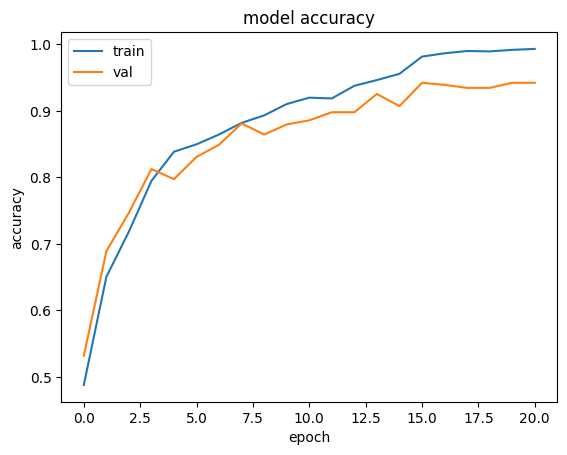

In [40]:
plt.plot(myModel.history['accuracy'])
plt.plot(myModel.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

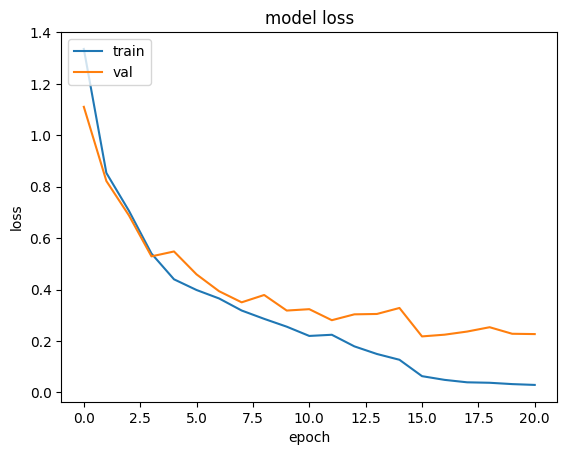

In [41]:
plt.plot(myModel.history['loss'])
plt.plot(myModel.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')